# Clustering for Semi-Supervised Learning on Fashion MNIST dataset

by
- Sampad Kumar Kar
- Shankar Ram Vasudevan

# The Dataset

## Context

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."

Zalando seeks to replace the original MNIST dataset

## Content

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.


## Labels

Each training and test example is assigned to one of the following labels:

- `0` T-shirt/top
- `1` Trouser
- `2` Pullover
- `3` Dress
- `4` Coat
- `5` Sandal
- `6` Shirt
- `7` Sneaker
- `8` Bag
- `9` Ankle boot


## Dataset Summary

- Each row is a separate image
- Column `1` is the class label.
- Remaining columns are pixel numbers (`784` total).
- Each value is the darkness of the pixel (`1` to `255`)

# Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", keras.__version__)

Tensorflow Version:  2.7.0
Keras Version:  2.7.0


# Loading the Dataset

We first load and analyse the fashion MNIST dataset.

Note: The dataset is already split into training and test sets for us.

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
print(X_train_full.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


As we can see, the training set contains 60000 examples and the test set contains 10000 examples.

Each example here represents a $28 \times 28$ greyscale image.

In [5]:
X_train_full.dtype

dtype('uint8')

Each entry represents a pixel intensity, which is an integer between `0` to `255`.

We now split the full training set into a validation set and (smaller) training set. We also scale the pixel intensities down to the `0-1` range and convert them into floats by dividing by `255`.

In [6]:
X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.

Note that the labels are class IDs (represented as integers), from `0` to `9`.

In [8]:
y_train.dtype

dtype('uint8')

Here are the corresponding class names, which we store them in an array to use them.

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Data Visualization

We pick a few images (images are already shuffled in the dataset) and display them with their respective labels.

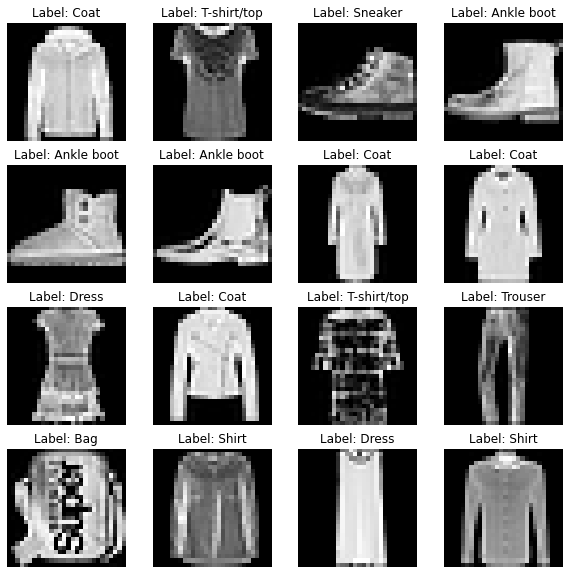

In [14]:
num_images = 16 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(10,10))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_train[index], cmap='gray')
        ax[row,col].set_title('Label: ' + class_names[y_train[index]])
        ax[row,col].set_axis_off()
        index += 1

plt.show()

If we closely observe, we can see that there are moderate variations in the appearance of the images (say, the first image, i.e. the image of `Coat`
). These matrices are also close to sparse (that is, ther are lots of zeros (black pixels) in the matrix than non-zero pixels).

Let's look at a single example first.

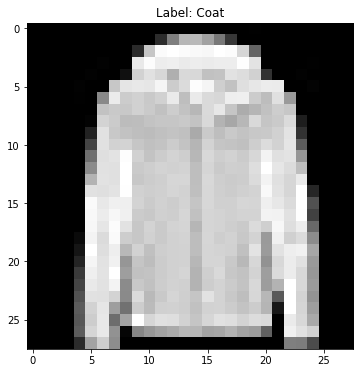

In [13]:
plt.figure(figsize=(6,6))
index = 0
plt.imshow(X_train[index], cmap='gray')
plt.title('Label: ' + class_names[y_train[index]])
plt.show()

Before proceeding further, we need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of samples in each class.

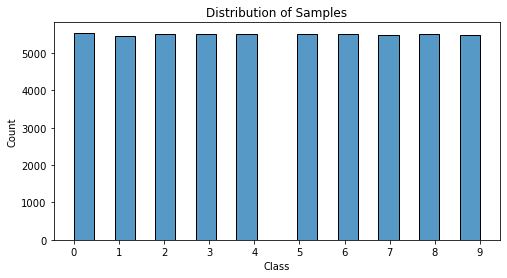

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(data=y_train, binwidth=0.45, bins=11)
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

The data seems pretty balanced, as each label is almost equally represented.

# Semi-Supervised Learning

# Neural Network

Before we start with any learning, we define the neural netwrok first. In this notebook, we start with a network with 4 layers-
- First layer with $784$ nodes (which is the flattened version of the $28 \times 28$ input)
- $2$ hidden layers with $300$ and $100$ nodes respectively, with `relu` as the activation.
- Lastly we have the output layer consisting of $10$ nodes corresponding the `10` possible labels, along with `softmax` activation.

In [19]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-20 09:33:53.177906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-20 09:33:53.179621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Let's analyse one of the hidden layers before the training begins. We will be analysing the first hidden layer of this network.

In [22]:
hidden_layer_1 = model.layers[1]
hidden_layer_1.name

'dense'

In [26]:
weights, biases = hidden_layer_1.get_weights()
print(weights.shape, biases.shape, sep='\n')

(784, 300)
(300,)


Let's define the loss function and evaluation metric for the model.

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

## Semi-Supervised Strategy 1

As our first strategy, we train our model on just $50$ labelled instances and try evaluating it's performance on the test set.

In [28]:
n_labels = 50

As a first test, we train on $200$ epochs and plot the learning curve.

In [29]:
history = model.fit(X_train[:n_labels], y_train[:n_labels], epochs=200, validation_data=(X_valid, y_valid))

2022-05-20 09:58:39.262450: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2022-05-20 09:58:39.493336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 2.3010 - accuracy: 0.0800

2022-05-20 09:58:42.709287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 1s/step - loss: 2.3010 - accuracy: 0.0800 - val_loss: 2.3168 - val_accuracy: 0.0996
Epoch 2/200
2/2 [==============================] - 1s 594ms/step - loss: 2.2019 - accuracy: 0.1800 - val_loss: 2.2725 - val_accuracy: 0.1258
Epoch 3/200
2/2 [==============================] - 1s 588ms/step - loss: 2.1225 - accuracy: 0.1800 - val_loss: 2.2357 - val_accuracy: 0.1506
Epoch 4/200
2/2 [==============================] - 1s 635ms/step - loss: 2.0506 - accuracy: 0.2400 - val_loss: 2.2023 - val_accuracy: 0.1724
Epoch 5/200
2/2 [==============================] - 1s 612ms/step - loss: 1.9880 - accuracy: 0.3200 - val_loss: 2.1723 - val_accuracy: 0.2060
Epoch 6/200
2/2 [==============================] - 1s 588ms/step - loss: 1.9263 - accuracy: 0.3800 - val_loss: 2.1487 - val_accuracy: 0.2166
Epoch 7/200
2/2 [==============================] - 1s 584ms/step - loss: 1.8761 - accuracy: 0.3800 - val_loss: 2.1191 - val_accuracy: 0.2520
Epoch 8/200
2/2 [===========

In [30]:
history.params

{'verbose': 1, 'epochs': 200, 'steps': 2}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's look at the learning curve.

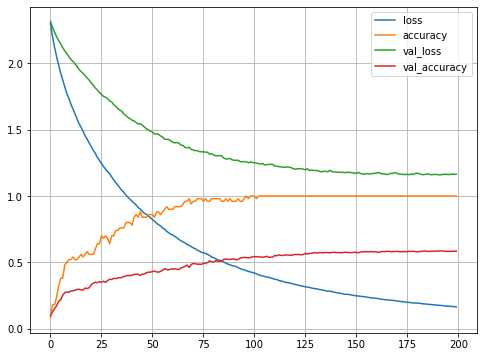

In [35]:
pd.DataFrame(history.history).plot(figsize=(8,6))
plt.grid(True)
plt.show()

From the diagram, it seems 100 epochs are enough to reach a satisfying model.

Let's evaluate the model on the test set.

In [37]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

n_labels = 50

history = model.fit(X_train[:n_labels], y_train[:n_labels], epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 2.5865 - accuracy: 0.0625

2022-05-20 10:10:48.310861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-20 10:10:48.505537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 776ms/step - loss: 2.5323 - accuracy: 0.0600 - val_loss: 2.3857 - val_accuracy: 0.0404
Epoch 2/100
2/2 [==============================] - 1s 646ms/step - loss: 2.3880 - accuracy: 0.0800 - val_loss: 2.3200 - val_accuracy: 0.0578
Epoch 3/100
2/2 [==============================] - 1s 585ms/step - loss: 2.2872 - accuracy: 0.1200 - val_loss: 2.2800 - val_accuracy: 0.0956
Epoch 4/100
2/2 [==============================] - 1s 585ms/step - loss: 2.2163 - accuracy: 0.1800 - val_loss: 2.2473 - val_accuracy: 0.1434
Epoch 5/100
2/2 [==============================] - 1s 587ms/step - loss: 2.1569 - accuracy: 0.2600 - val_loss: 2.2210 - val_accuracy: 0.1744
Epoch 6/100
2/2 [==============================] - 1s 587ms/step - loss: 2.0991 - accuracy: 0.3200 - val_loss: 2.1996 - val_accuracy: 0.2076
Epoch 7/100
2/2 [==============================] - 1s 589ms/step - loss: 2.0542 - accuracy: 0.3600 - val_loss: 2.1758 - val_accuracy: 0.2404
Epoch 8/100
2/2 [========

In [43]:
y_test_prob = model.predict(X_test)

In [46]:
y_test_hat = np.argmax(y_test_prob, axis=1)
y_test_hat

array([9, 2, 1, ..., 3, 3, 9])

In [49]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1000
           1       1.00      0.48      0.65      1000
           2       0.51      0.64      0.56      1000
           3       0.47      0.73      0.57      1000
           4       0.31      0.60      0.41      1000
           5       0.51      0.35      0.41      1000
           6       0.28      0.05      0.08      1000
           7       0.35      0.11      0.16      1000
           8       0.75      0.64      0.69      1000
           9       0.52      0.95      0.67      1000

    accuracy                           0.52     10000
   macro avg       0.54      0.52      0.49     10000
weighted avg       0.54      0.52      0.49     10000



We obtain a meagre accuracy of `0.52` by training the model on $50$ examples. Let's proceed to the next strategy.

## Semi-Supervised Strategy 2

As the next strategy, we use clustering strategy to create newer labels for learning. This strategy will enable us to label the majority of the unlabelled datas in the training dataset to be usable for training purposes.

### Strategy 2.1

First, let's cluster the training set into $50$ clusters and see if we can do better. For each cluster, we find the image closest to the centroid. We will call these images the representative images.

Next, we plot these representative images and label them manually.
(Instead of labelling them myself, I will make use of the original labelled dataset to label them, assuming I would have labelled the data with a $100\%$ accuracy).

This will give us $50$ labelled instances again, but instead of being completely random instances, each of them would be a representative image of its cluster. Let's see if it results in any better performance.

Before we start clustering, we need to flatten the $28 \times 28$ matrices into vectors of length $784$.

In [22]:
X_train_flat = np.array([x.ravel() for x in X_train])
X_train_flat.shape

(55000, 784)

We can now cluster on `X_train_flat`.

In [1]:
k = 50

In [23]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_train_dist = kmeans.fit_transform(X_train_flat)
representative_idx = np.argmin(X_train_dist, axis=0)

X_train_rep = X_train[representative_idx]
y_train_rep = y_train[representative_idx]

Let's train our model on this dataset.

In [27]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train_rep, y_train_rep, epochs=150, validation_data=(X_valid, y_valid))

Epoch 1/150
1/2 [==============>...............] - ETA: 0s - loss: 2.2033 - accuracy: 0.1562

2022-05-20 18:55:44.446722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-20 18:55:44.767988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 867ms/step - loss: 2.2362 - accuracy: 0.1200 - val_loss: 2.2983 - val_accuracy: 0.1246
Epoch 2/150
2/2 [==============================] - 1s 608ms/step - loss: 2.1329 - accuracy: 0.1800 - val_loss: 2.2380 - val_accuracy: 0.1696
Epoch 3/150
2/2 [==============================] - 1s 592ms/step - loss: 2.0541 - accuracy: 0.3000 - val_loss: 2.1898 - val_accuracy: 0.2122
Epoch 4/150
2/2 [==============================] - 1s 658ms/step - loss: 1.9876 - accuracy: 0.3000 - val_loss: 2.1587 - val_accuracy: 0.2268
Epoch 5/150
2/2 [==============================] - 1s 627ms/step - loss: 1.9212 - accuracy: 0.3600 - val_loss: 2.1262 - val_accuracy: 0.2548
Epoch 6/150
2/2 [==============================] - 1s 659ms/step - loss: 1.8670 - accuracy: 0.3800 - val_loss: 2.0859 - val_accuracy: 0.2888
Epoch 7/150
2/2 [==============================] - 1s 672ms/step - loss: 1.8227 - accuracy: 0.4600 - val_loss: 2.0585 - val_accuracy: 0.3032
Epoch 8/150
2/2 [========

Let's plot the learning curve.

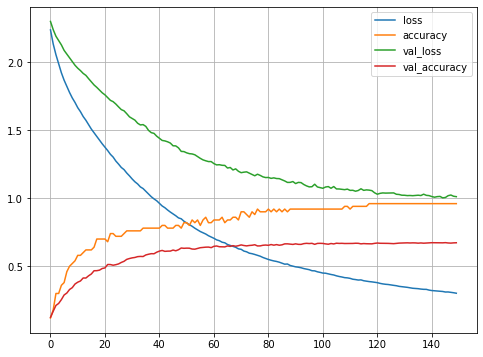

In [28]:
pd.DataFrame(history.history).plot(figsize=(8,6))
plt.grid(True)
plt.show()

The values seems to have stabilized around $125$ epochs.

Let's evaluate the model on the test set.

In [29]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train_rep, y_train_rep, epochs=125, validation_data=(X_valid, y_valid))

Epoch 1/125
1/2 [==============>...............] - ETA: 0s - loss: 2.4052 - accuracy: 0.0000e+00

2022-05-20 18:58:17.884695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-20 18:58:18.072417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 737ms/step - loss: 2.3670 - accuracy: 0.0000e+00 - val_loss: 2.4061 - val_accuracy: 0.0698
Epoch 2/125
2/2 [==============================] - 1s 680ms/step - loss: 2.2704 - accuracy: 0.0800 - val_loss: 2.3477 - val_accuracy: 0.0890
Epoch 3/125
2/2 [==============================] - 1s 597ms/step - loss: 2.1920 - accuracy: 0.1000 - val_loss: 2.2965 - val_accuracy: 0.1370
Epoch 4/125
2/2 [==============================] - 1s 603ms/step - loss: 2.1286 - accuracy: 0.2200 - val_loss: 2.2639 - val_accuracy: 0.1852
Epoch 5/125
2/2 [==============================] - 1s 592ms/step - loss: 2.0608 - accuracy: 0.3400 - val_loss: 2.2267 - val_accuracy: 0.2526
Epoch 6/125
2/2 [==============================] - 1s 608ms/step - loss: 2.0056 - accuracy: 0.4600 - val_loss: 2.1908 - val_accuracy: 0.2922
Epoch 7/125
2/2 [==============================] - 1s 634ms/step - loss: 1.9650 - accuracy: 0.4800 - val_loss: 2.1645 - val_accuracy: 0.3078
Epoch 8/125
2/2 [====

In [30]:
y_test_prob = model.predict(X_test)

2022-05-20 19:00:48.549202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [31]:
y_test_hat = np.argmax(y_test_prob, axis=1)
y_test_hat

array([9, 2, 1, ..., 8, 3, 7])

In [32]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.61      0.85      0.71      1000
           1       0.98      0.84      0.90      1000
           2       0.45      0.80      0.58      1000
           3       0.72      0.73      0.73      1000
           4       0.51      0.30      0.38      1000
           5       1.00      0.00      0.00      1000
           6       0.64      0.28      0.39      1000
           7       0.60      0.82      0.69      1000
           8       0.91      0.89      0.90      1000
           9       0.59      0.96      0.73      1000

    accuracy                           0.65     10000
   macro avg       0.70      0.65      0.60     10000
weighted avg       0.70      0.65      0.60     10000



Voila! The accuracy jumped from `0.52` to `0.65`!

### Strategy 2.2

Now, we go one step further, we propagate the labels of the representative example to all the points in its cluster and then use the whole labelled set as the training data of the neural network.

In [33]:
y_train_propagated = np.empty(len(y_train), dtype=np.int)
# k = 50
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_train_rep[i]

Let's train our model on the propagated dataset.

In [37]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train_propagated, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
  22/1719 [..............................] - ETA: 8s - loss: 2.0568 - accuracy: 0.2585

2022-05-20 19:18:59.935415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1714/1719 [============================>.] - ETA: 0s - loss: 0.5367 - accuracy: 0.8166

2022-05-20 19:19:07.719831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 8s 5ms/step - loss: 0.5363 - accuracy: 0.8166 - val_loss: 1.1164 - val_accuracy: 0.6998
Epoch 2/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3312 - accuracy: 0.8713 - val_loss: 1.2418 - val_accuracy: 0.6996
Epoch 3/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2956 - accuracy: 0.8844 - val_loss: 1.3534 - val_accuracy: 0.6894
Epoch 4/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2715 - accuracy: 0.8936 - val_loss: 1.4000 - val_accuracy: 0.6974
Epoch 5/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2509 - accuracy: 0.9008 - val_loss: 1.4553 - val_accuracy: 0.7018
Epoch 6/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2340 - accuracy: 0.9077 - val_loss: 1.4955 - val_accuracy: 0.7002
Epoch 7/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2180 - accuracy: 0.9133 - val_loss: 1.5998 - val_accuracy: 0.6906
Epo

Let's plot the learning curve.

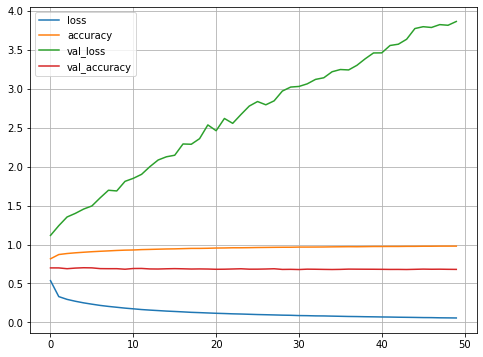

In [38]:
pd.DataFrame(history.history).plot(figsize=(8,6))
plt.grid(True)
plt.show()

Around $20$ iterations seem enough.

Let's evaluate the model on the test set.

In [39]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train_propagated, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
  20/1719 [..............................] - ETA: 9s - loss: 2.1695 - accuracy: 0.2766

2022-05-20 19:28:57.238266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8152

2022-05-20 19:29:05.905611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 9s 5ms/step - loss: 0.5421 - accuracy: 0.8152 - val_loss: 1.1225 - val_accuracy: 0.6984
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3381 - accuracy: 0.8669 - val_loss: 1.2465 - val_accuracy: 0.6992
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2984 - accuracy: 0.8830 - val_loss: 1.3463 - val_accuracy: 0.6902
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2710 - accuracy: 0.8931 - val_loss: 1.3923 - val_accuracy: 0.6970
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2481 - accuracy: 0.9024 - val_loss: 1.4741 - val_accuracy: 0.7000
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2292 - accuracy: 0.9093 - val_loss: 1.5206 - val_accuracy: 0.6976
Epoch 7/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2128 - accuracy: 0.9160 - val_loss: 1.5939 - val_accuracy: 0.6928
Epo

In [40]:
y_test_prob = model.predict(X_test)

2022-05-20 19:31:53.609672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [41]:
y_test_hat = np.argmax(y_test_prob, axis=1)
y_test_hat

array([9, 2, 1, ..., 8, 1, 7])

In [42]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.65      0.79      0.72      1000
           1       0.99      0.87      0.93      1000
           2       0.46      0.59      0.51      1000
           3       0.73      0.72      0.73      1000
           4       0.49      0.26      0.34      1000
           5       0.87      0.44      0.58      1000
           6       0.35      0.40      0.37      1000
           7       0.65      0.77      0.70      1000
           8       0.93      0.85      0.89      1000
           9       0.72      0.96      0.82      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.66     10000
weighted avg       0.68      0.67      0.66     10000



We got a tiny accuracy boost from `0.65` to `0.67`.

### Strategy 2.3

Instead of propagating the labels to all the points in the cluster, we should probably propagate the labels only to the instances closest to the centroid. This should help us avoid the outliers.

Let's only propagate the labels to the `75`th percentile closest to the centroid.

In [43]:
percentile_closest = 75

X_cluster_dist = X_train_dist[np.arange(len(y_train)), kmeans.labels_]

# k = 50
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [44]:
partially_propagated_idx = (X_cluster_dist != -1)
X_train_part_prop  = X_train[partially_propagated_idx]
y_train_part_prop = y_train[partially_propagated_idx]

Let's train our model on this dataset.

In [45]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train_part_prop, y_train_part_prop, epochs=75, validation_data=(X_valid, y_valid))

Epoch 1/75
  20/1289 [..............................] - ETA: 6s - loss: 2.1937 - accuracy: 0.2438    

2022-05-20 19:43:50.755050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1289/1289 [==============================] - ETA: 0s - loss: 0.7191 - accuracy: 0.7660

2022-05-20 19:43:57.257508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1289/1289 [==============================] - 7s 5ms/step - loss: 0.7191 - accuracy: 0.7660 - val_loss: 0.5546 - val_accuracy: 0.8216
Epoch 2/75
1289/1289 [==============================] - 7s 5ms/step - loss: 0.4517 - accuracy: 0.8436 - val_loss: 0.5073 - val_accuracy: 0.8304
Epoch 3/75
1289/1289 [==============================] - 7s 5ms/step - loss: 0.4027 - accuracy: 0.8574 - val_loss: 0.4727 - val_accuracy: 0.8386
Epoch 4/75
1289/1289 [==============================] - 7s 5ms/step - loss: 0.3778 - accuracy: 0.8675 - val_loss: 0.4569 - val_accuracy: 0.8460
Epoch 5/75
1289/1289 [==============================] - 7s 5ms/step - loss: 0.3591 - accuracy: 0.8732 - val_loss: 0.4403 - val_accuracy: 0.8510
Epoch 6/75
1289/1289 [==============================] - 7s 5ms/step - loss: 0.3463 - accuracy: 0.8794 - val_loss: 0.4336 - val_accuracy: 0.8528
Epoch 7/75
1289/1289 [==============================] - 7s 5ms/step - loss: 0.3343 - accuracy: 0.8835 - val_loss: 0.4373 - val_accuracy: 0.8556
Epo

Let's look at the learning curves.

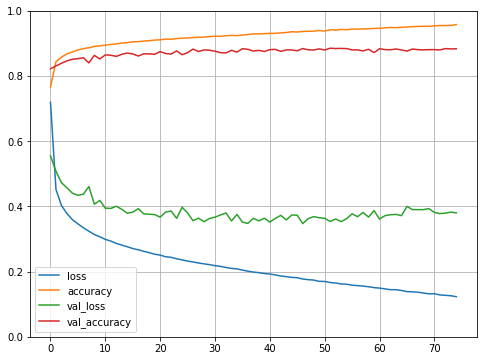

In [47]:
pd.DataFrame(history.history).plot(figsize=(8,6))
plt.grid(True)
plt.ylim(0,1)
plt.show()

This seems good enough.

Let's evaluate this on the test set.

In [48]:
y_test_prob = model.predict(X_test)

2022-05-20 19:54:05.451200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [49]:
y_test_hat = np.argmax(y_test_prob, axis=1)
y_test_hat

array([9, 2, 1, ..., 8, 1, 5])

In [50]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1000
           1       0.98      0.95      0.97      1000
           2       0.79      0.81      0.80      1000
           3       0.88      0.86      0.87      1000
           4       0.81      0.81      0.81      1000
           5       0.96      0.95      0.96      1000
           6       0.75      0.66      0.70      1000
           7       0.93      0.95      0.94      1000
           8       0.94      0.96      0.95      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



The accuracy jumps from `0.67` to `0.88`!

Let's try comparing this to a model trained on the full training dataset and see how our stragies fared.

## Supervised Learning

In [52]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
  21/1719 [..............................] - ETA: 9s - loss: 2.2009 - accuracy: 0.2068

2022-05-20 19:57:44.616072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1714/1719 [============================>.] - ETA: 0s - loss: 0.7362 - accuracy: 0.7568

2022-05-20 19:57:53.145273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 9s 5ms/step - loss: 0.7356 - accuracy: 0.7571 - val_loss: 0.5244 - val_accuracy: 0.8270
Epoch 2/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4915 - accuracy: 0.8286 - val_loss: 0.4367 - val_accuracy: 0.8524
Epoch 3/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4453 - accuracy: 0.8438 - val_loss: 0.5309 - val_accuracy: 0.8004
Epoch 4/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4189 - accuracy: 0.8539 - val_loss: 0.3968 - val_accuracy: 0.8664
Epoch 5/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4006 - accuracy: 0.8612 - val_loss: 0.3823 - val_accuracy: 0.8678
Epoch 6/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3823 - accuracy: 0.8657 - val_loss: 0.3741 - val_accuracy: 0.8746
Epoch 7/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3699 - accuracy: 0.8693 - val_loss: 0.3693 - val_accuracy: 0.8754
Epo

Let's plot the learning curves.

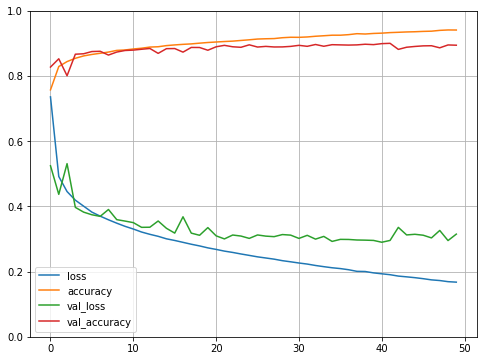

In [53]:
pd.DataFrame(history.history).plot(figsize=(8,6))
plt.grid(True)
plt.ylim(0,1)
plt.show()

Around $35$ epochs seem good enough.

Let's evaluate this on the test set.

In [58]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=35, validation_data=(X_valid, y_valid))

Epoch 1/35
  20/1719 [..............................] - ETA: 9s - loss: 2.1103 - accuracy: 0.2328 

2022-05-20 20:12:17.941282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.7601

2022-05-20 20:12:26.409541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 9s 5ms/step - loss: 0.7093 - accuracy: 0.7601 - val_loss: 0.5255 - val_accuracy: 0.8170
Epoch 2/35
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4848 - accuracy: 0.8295 - val_loss: 0.4374 - val_accuracy: 0.8520
Epoch 3/35
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4397 - accuracy: 0.8443 - val_loss: 0.5209 - val_accuracy: 0.8050
Epoch 4/35
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4131 - accuracy: 0.8553 - val_loss: 0.3939 - val_accuracy: 0.8668
Epoch 5/35
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3944 - accuracy: 0.8626 - val_loss: 0.3759 - val_accuracy: 0.8730
Epoch 6/35
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3759 - accuracy: 0.8664 - val_loss: 0.3744 - val_accuracy: 0.8690
Epoch 7/35
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3644 - accuracy: 0.8711 - val_loss: 0.3639 - val_accuracy: 0.8716
Epo

In [59]:
y_test_prob = model.predict(X_test)

2022-05-20 20:17:28.468449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [60]:
y_test_hat = np.argmax(y_test_prob, axis=1)
y_test_hat

array([9, 2, 1, ..., 8, 1, 5])

In [61]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.81      0.81      1000
           3       0.94      0.85      0.89      1000
           4       0.81      0.82      0.82      1000
           5       0.96      0.97      0.97      1000
           6       0.67      0.75      0.71      1000
           7       0.96      0.93      0.94      1000
           8       0.98      0.96      0.97      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



The fully labelled training set scores `0.89`, which is merely `0.01` better than our semi-supervised model via **Strategy 2.3**!

# Summary

- We use semi-supervised learning to learn a fairly accurate neural network based on the fashion MNIST dataset.
- We employed the following strategies of semi-supervised learning:
    - **Strategy 1:** We train our model on just $50$ randomly labelled instances. We obtain an accuracy of $52\%$.
    - **Strategy 2:** We use clustering strategy to create newer labels for learning. This enables us to label the majority of unlabelled data with just a few labels. We did that in the following ways:
        - **Strategy 2.1:** We first cluster the training set into $50$ clusters and for each cluster we select the image closest to the centroid point and choose it as the representative image of the cluster. Then we collect these $50$ images and manually label them and train the model on these. This gives us an accuracy of $65\%$.
        - **Strategy 2.2:** We go one step further from **Strategy 2.1** and propagate the labels of the representative example to all the points in its cluster and then use the whole labelled set as the training data. This gives an accuracy of $67\%$.
        - **Strategy 2.3:** Instead of propagating the label of representative to all of the points in the cluster as in **Strategy 2.2**, we instead propagate the labels to the `75`th percentile closest to the centroid. This gives us a huge improvement and takes the accuracy to $88\%$.
- We also employ supervised learning and use the original training set to train the model. We achieve a meagre improvement of $1\%$ over **Strategy 2.3**. This demonstrates the advantage and powers of semi-supervised learning in the machine learning paradigm.